# Project by: Jeorval Jose Cano Morales

In [187]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.firefox import GeckoDriverManager
import re

from collections import Counter

import time
from bs4 import BeautifulSoup

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. Mapping of the social Network

In [36]:
class Facebook_friends_Network:
    """
    Class which its main purpouse is to get the social network graph of faceboob friends of a given person, it works
    by web scraping the friends of a given account and then each friends is visited to get mutual friends to construct
    the social network of a given facebook account
    
    """
    
    def __init__(self, email, password, username):
        """
        initializer of the class
        
        Input:
        email: email of a facebook account
        password: password to get access to the facebook account
        username: it is the username of the facebook profile, you can find it going into your profile and looking in the link
                  https://www.facebook.com/{YOUR USERNAME IS HERE}
        """
        self.email = email
        self.password = password
        self.username = username

        #saving the tag and class on the html of facebook friends
        self.friend_class = 'oajrlxb2 g5ia77u1 qu0x051f esr5mh6w e9989ue4 r7d6kgcz rq0escxv nhd2j8a9 nc684nl6 p7hjln8o kvgmc6g5 cxmmr5t8 oygrvhab hcukyx3x jb3vyjys rz4wbd8a qt6c0cv9 a8nywdso i1ao9s8h esuyzwwr f1sip0of lzcic4wl gmql0nx0 gpro0wi8'
        self.tag = 'a'
        
        #initalizing the driver
        self.driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())
        self.wait = WebDriverWait(self.driver, 5)
        
        #making the bot to log in on the given account
        self.log_in()
        
        
    def log_in(self):
        """
        Function to log in the facebook account. 
        
        It does not receive any argument since uses class' atributtes
        """
        self.driver.get('http://www.facebook.com')
        
        # wait for the login page to load
        self.wait.until(EC.visibility_of_element_located((By.ID, "email")))
        
        #writing the email in the corresponding box
        self.driver.find_element_by_id('email').send_keys(self.email)
        
        #writing the password in the corresponding box
        self.driver.find_element_by_id('pass').send_keys(self.password)
        
        #clicking on the log in button
        self.driver.find_element_by_name('login').click()

         # wait for the main page to load
        time.sleep(5)
        
        
        
    def _infinite_scroll(self):
        """
        Function to scroll down the full page
        
        IMPORTANT NOTE:
        If the page does not charge in the pause time given the loop is going to break even though it is not in the very down on the page
        """
        #time to wait for the new contact to load
        pause_time = 10
        
        #height of the window screen
        height = self.driver.execute_script("return window.screen.height;")
        i = 1

        while True:
            # scroll one screen height each time
            self.driver.execute_script("window.scrollTo(0, {}*{});".format(height, i))  
            i += 1
            time.sleep(pause_time)
            
            scroll_height = self.driver.execute_script("return document.body.scrollHeight;")  
            
            # Break the loop when the height we need to scroll to is larger than the total scroll height
            if (height) * i > scroll_height:
                break
        
    def get_friends(self):
        """
        Function to get the friends list of the facebook accoun the class is logged in
        
        It does not receive arguments ,only uses attributes
        """
        
        #get to the page where your contact list is
        self.driver.get('https://www.facebook.com/{}/friends'.format(self.username))
        
        #scrolling down
        self._infinite_scroll()
        
        #getting the html of the full page
        html = self.driver.page_source
        #parsing it
        soup = BeautifulSoup(html, "html.parser")
        
        #look for the tag and class where the friend name is and also their id
        raw_data = soup.find_all(self.tag, class_ = self.friend_class)
        
        #dict to save the id of facebook friend, the key is the real name of the user
        id_dict = dict()
        
        #looping to the raw data to get the name and id
        for elem in raw_data:
            
            #getting the id
            fb_id = re.findall('https://www.facebook.com/([a-zA-Z0-9,.]+)', str(elem))[0]
            
            #case where it is not a proper id
            if fb_id == 'profile.php':
                continue
                
            if fb_id == 'pages':
                break
            
            #getting the name of the fb friend
            real_name = elem.get_text()
            
            #saving the values
            id_dict[real_name] = fb_id 
            
        #making the id_dict into an attribute to use later on
        self.id_dict = id_dict
        
        
    def get_mutual_friends(self):
        """
        Function to get the mutual friends of each of your friends in facebook given the account in the initializer
        """
        
        #dict where the info of mutual name is going to be save, the key is the id of the friend where a visiting
        #and the value is a list of ids of the mutual friends
        dict_friends = dict()
        
        #iteraring through the facebook friends
        for friend in self.id_dict.values():
            
            #going to the page where the mutual friends are
            self.driver.get('https://www.facebook.com/{}/friends_mutual'.format(friend))
            
            time.sleep(6)
            
            #scrolling down
            self._infinite_scroll()
            
            #getting the html of the full page
            html = self.driver.page_source
            #parsing it
            soup = BeautifulSoup(html, "html.parser")

            #look for the tag and class where the friend name is and also their id
            raw_data = soup.find_all(self.tag, class_ = self.friend_class)
            
            #list to save the mutual friends' id of the current friend
            friends_of_friend = []
            
            #getting the friends' id and their real names
            for elem in raw_data:
                
                #case where it goes beyond mutual friends, as videos and that kind of things
                try:
                    fb_id = re.findall('https://www.facebook.com/([a-zA-Z0-9,.]+)', str(elem))[0]
                    
                except:
                    break
                
                #case where it reaches a point where all the reamining are pages liked or groups shared
                if fb_id == 'pages':
                    break
                
                if fb_id == 'profile.php':
                    continue

                real_name = elem.get_text()
                
                friends_of_friend.append(fb_id)
                
            dict_friends[friend] = friends_of_friend  
                    
            
        self.dict_friends = dict_friends
        
        
    def create_graph(self):
        """
        Function to create the graph of a social facebook friend network
        
        It does not receive anything
        """
        #getting friend list
        self.get_friends()
        
        #getting mutual friends of each friend
        self.get_mutual_friends()
        
        #initializing empty graph
        G = nx.Graph()
        
        #creating the the fist node and edges, the given account and their friends 
        for friend in self.id_dict.values():
            
            G.add_edge(self.username, friend)
        
        #creating the relationship among the friends of the given fb account
        #first iterate in each friend, the key
        for person in self.dict_friends:

            #second iterate over the list of mutual friends
            for friend in self.dict_friends[person]:

                G.add_edge(person, friend)
                
        self.Graph = G 
        
        return G

#### Note:
Obviusly, when I ran the progam I used my facebook account, however; for security I eliminated the credentials.

In [37]:
facebook_g = Facebook_friends_Network('{HERE IT WAS MY EMAIL}','{HERE MY PASSWORD}', 'jeorval.canomorales')



====== WebDriver manager ======
Current firefox version is 90.0.2
Get LATEST driver version for 90.0.2
Driver [C:\Users\jeorv\.wdm\drivers\geckodriver\win64\v0.29.1\geckodriver.exe] found in cache


In [38]:
G = facebook_g.create_graph()

### NOTE:
After doing the web scraping which took 3 hours, I noticed that some friends that appear are web pages or groups, even though I made a break to avoid the majority some of them still appear, so I manually eliminated them, and this it has to be done in this way.

In [77]:
G = G_copy.copy()

In [44]:
list(facebook_g.id_dict.keys())[-4:]

['Christopher Ramirez',
 'Fraccionamiento Residencial Los Héroes',
 'UNO',
 'Escuela Preparatoria Uno']

The last three ones are not part of friends.

In [45]:
copy = facebook_g.id_dict.copy()

copy.pop('Fraccionamiento Residencial Los Héroes', None)

copy.pop('UNO', None)

copy.pop('Escuela Preparatoria Uno', None)

'Prepa1UADY'

In [62]:
facebook_g.id_dict = copy.copy()

### Cleaning.

As it happens in getting the friends list of your fb account, sometimes also appear in other friends. So we are going to eliminate nodes that are not in facebook_g.id_dict because if they are not there, they are not your friends

In [83]:
G_c = G.copy()

for node in G_c:
     
    if node not in list(facebook_g.id_dict.values()) and node != facebook_g.username:
        
        G.remove_node(node)

In [161]:
nx.readwrite.adjlist.write_adjlist(G, 'facebook_friends_network.adjlist')

## Only reading the file and not do web scrapping

In [ ]:
# G = nx.readwrite.adjlist.read_adjlist('facebook_friends_network.adjlist')

# 2.Visualization of the social network

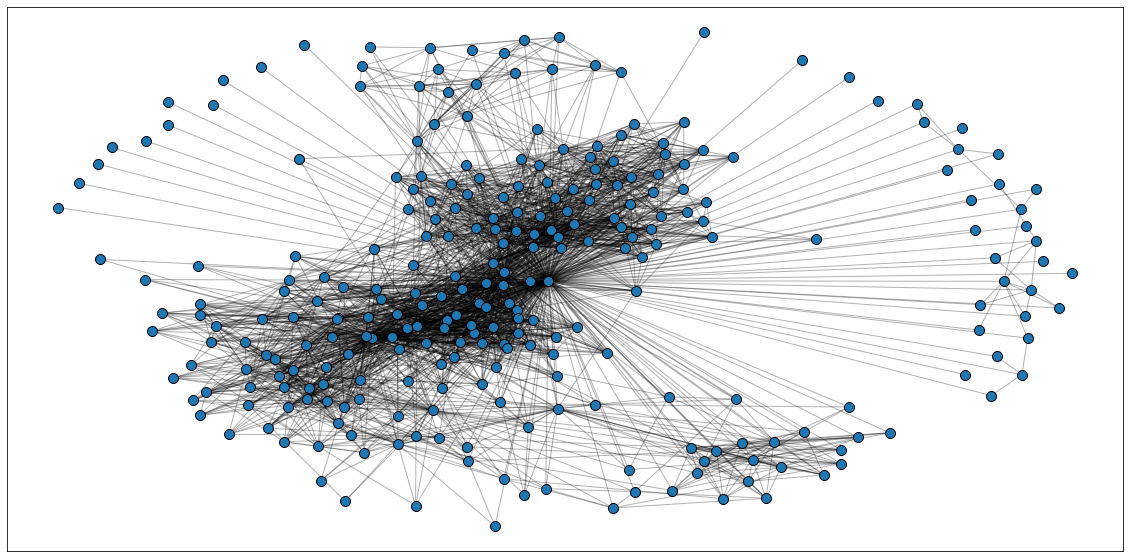

In [183]:
# Network Visualization
plt.figure(figsize = (20, 10))
pos = nx.spring_layout(G, seed = 23)
nx.draw_networkx_nodes(G, pos = pos, node_size = 100, edgecolors = 'black')
nx.draw_networkx_edges(G, pos = pos, alpha = 0.3)
plt.show()

# 3. Network basic characteristics

In [90]:
print("Number of nodes: ", G.number_of_nodes())

Number of nodes:  280


In [91]:
print("Number of edges: ", G.number_of_edges())

Number of edges:  2981


In [92]:
avg = nx.algorithms.shortest_paths.generic.average_shortest_path_length(G)
print("Average shortest path: ", avg)

Average shortest path:  1.9236815156169995


In [93]:
d = nx.classes.function.density(G)
print("Density: ", d)

Density:  0.07631848438300051


In [94]:
cc = nx.algorithms.cluster.average_clustering(G)
print("Cluster coefficient: ", cc)

Cluster coefficient:  0.5338240890092355


In [95]:
diameter = nx.algorithms.distance_measures.diameter(G)
print("Diameter: ", diameter)

Diameter:  2


In [96]:
radius = nx.algorithms.distance_measures.radius(G)
print("Eccentricity: ", radius)

Eccentricity:  1


In [97]:
periphery = nx.algorithms.distance_measures.periphery(G)
print("{} nodes are the periphery".format(len(periphery)))

279 nodes are the periphery


In [98]:
center = nx.algorithms.distance_measures.center(G)
print("{} nodes are the center".format(len(center)))

1 nodes are the center


### Centrality measures

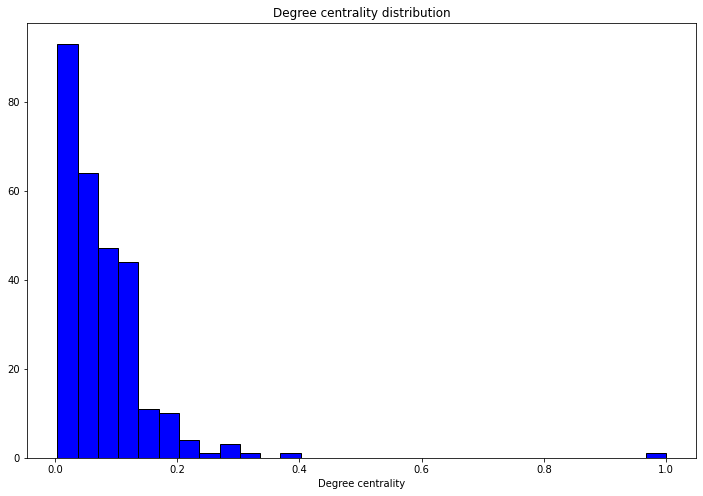

In [99]:
degree_c = nx.algorithms.centrality.degree_centrality(G)

#getting the degrees of each node
values = [degree_c[dgr] for dgr in degree_c]
#counting the degrees
count = Counter(values)

deg, cnt = zip(*count.items())

plt.figure(figsize=(12, 8))
plt.hist(values, bins = 30, color = 'blue', edgecolor = 'black')
plt.xlabel('Degree centrality')
plt.title('Degree centrality distribution')
plt.show()

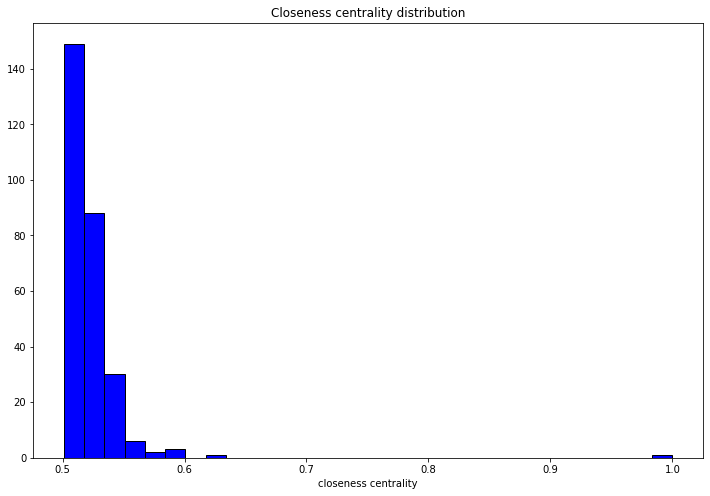

In [100]:
closeness_c = nx.algorithms.centrality.closeness_centrality(G)

#getting the degrees of each node
values = [closeness_c[dgr] for dgr in closeness_c]
#counting the degrees
count = Counter(values)

deg, cnt = zip(*count.items())

plt.figure(figsize=(12, 8))
plt.hist(values, bins = 30, color = 'blue', edgecolor = 'black')
plt.xlabel('closeness centrality')
plt.title('Closeness centrality distribution')
plt.show()

### Degree distribution

In [291]:
#getting the degrees of each node
values = [dgr[1] for dgr in G.degree()]
#counting the degrees
count = Counter(values)

deg, cnt = zip(*count.items())

In [292]:
max(deg)

279

In [293]:
min(deg)

1

In [294]:
print("average degree: ", np.mean(values))

average degree:  21.292857142857144


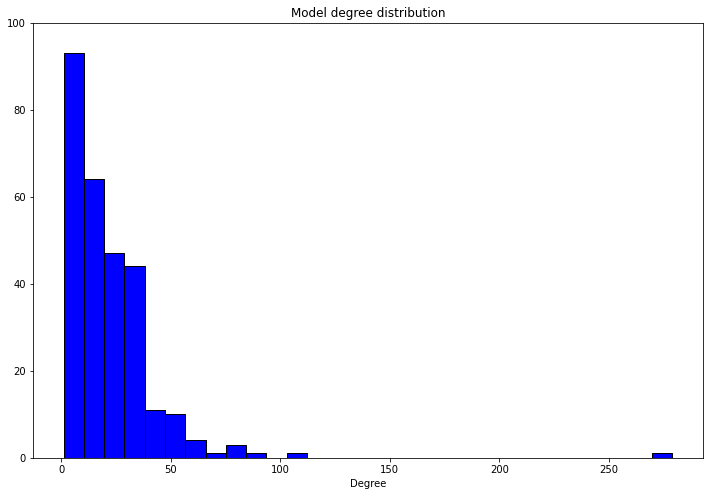

In [298]:
plt.figure(figsize=(12, 8))
plt.hist(values, bins = 30, color = 'blue', edgecolor = 'black')
plt.xlabel('Degree')
plt.title('Model degree distribution')
plt.ylim([0,100])
plt.show()

#### Nodes with degree 1 

In [197]:
len(np.array(values)[np.array(values) == 1])

23

## Community Detection

In [107]:
greedy = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

In [158]:
node_colors = []

for node in G.nodes:
    
    if node == facebook_g.username:
        
        node_colors.append('blue')
        G.nodes[node]['Community'] = 'All'
        continue
    
    if node in list(greedy[0]):     
        node_colors.append('red')
        G.nodes[node]['Community'] = 0
        continue
        
    elif node in list(greedy[1]):
        node_colors.append('orange')
        G.nodes[node]['Community'] = 1
        continue
        
    elif node in list(greedy[2]): 
        node_colors.append('green')   
        G.nodes[node]['Community'] = 2
        continue
        
    elif node in list(greedy[3]):
        node_colors.append('purple')  
        G.nodes[node]['Community'] = 3
        continue
        

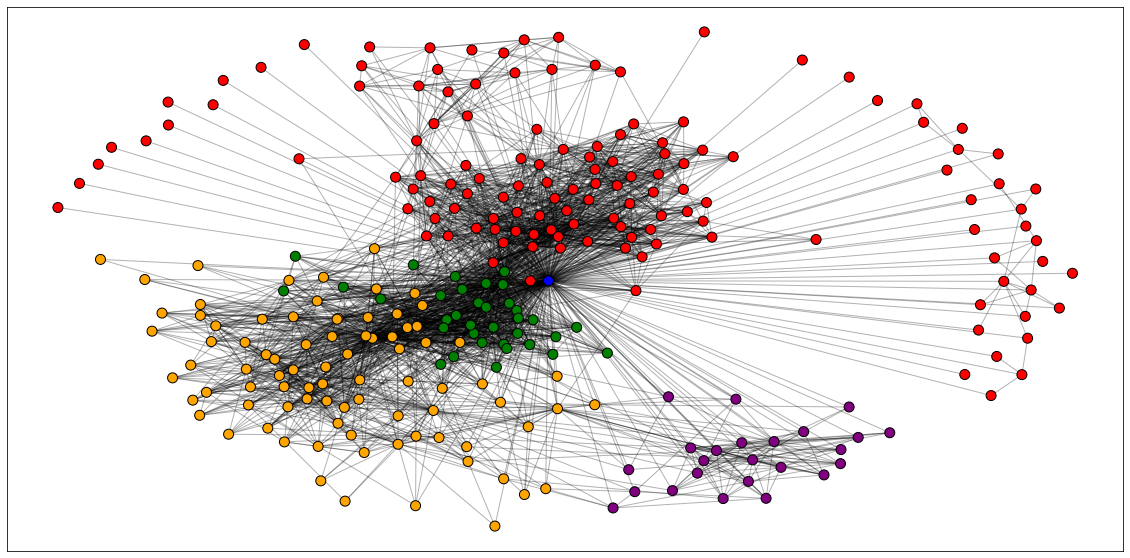

In [159]:
# Network Visualization
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G, pos = pos, alpha = 0.3)
plt.show()

In [160]:
G.nodes['jeorval.canomorales']

{'Community': 'All'}

## Link Prediction

In [198]:
#list to save pairs of nodes that does not have a edge between them
not_connected_nodes = []

for nodeA in G.nodes:
    
    for nodeB in G.nodes:
        
        #checking is not the same node and they do not have an edge
        if (nodeA != nodeB) and ((nodeA, nodeB) not in G.edges) and ((nodeB, nodeA) not in G.edges):
            
            #since is not a directed graph, this conditional is to avoid to repeat pairs
            if (nodeB, nodeA) not in not_connected_nodes:
                not_connected_nodes.append((nodeA, nodeB))
                
            else:
                continue

In [206]:
print("number of not connected pairs: ", len(not_connected_nodes))

number of not connected pairs:  36079


In [207]:
link_prediction_ra = list(nx.algorithms.link_prediction.ra_index_soundarajan_hopcroft(G, not_connected_nodes, community='Community'))

In [220]:
link_prediction_ra = np.array(link_prediction_ra)

#### Max and Min score

In [272]:
max(link_prediction_ra[:,2].astype(float))

1.1490092209132454

In [274]:
min(link_prediction_ra[:,2].astype(float))

0.0

### Obtaining pairs that score is greater than the treshold

In [227]:
edges_to_add = link_prediction_ra[link_prediction_ra[:,2].astype(float) > .3]

In [281]:
print("new edges to add: ", len(edges_to_add))

new edges to add:  627


In [231]:
G_copy = G.copy()

In [232]:
for nodeA, nodeB in edges_to_add[:,:2]:
    
    G_copy.add_edge(nodeA, nodeB)    

## Comparing network prior adding edges to after adding edges

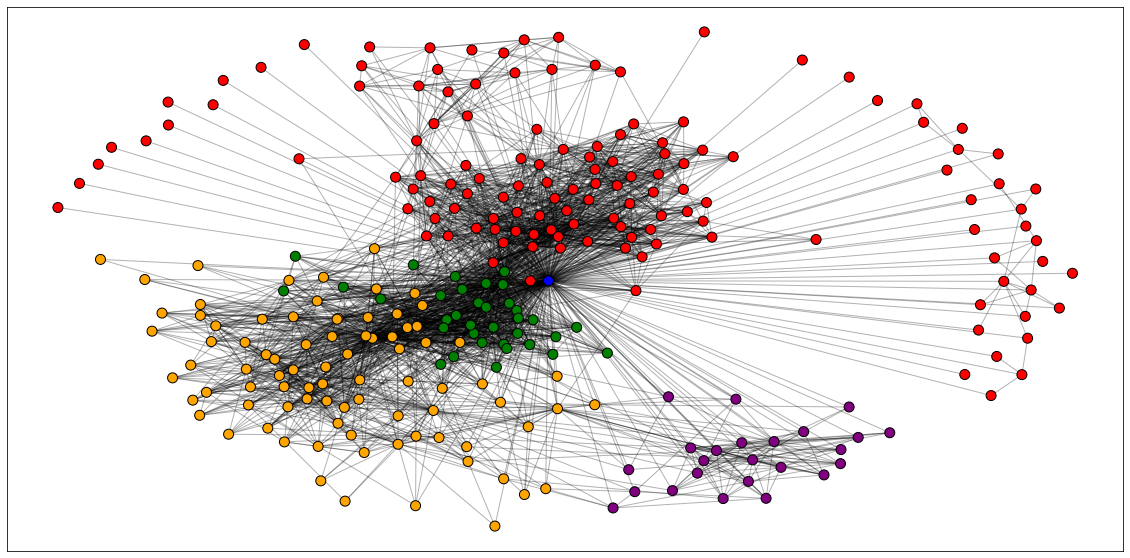

In [284]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G, pos = pos, alpha = 0.3)
plt.show()

### New edges

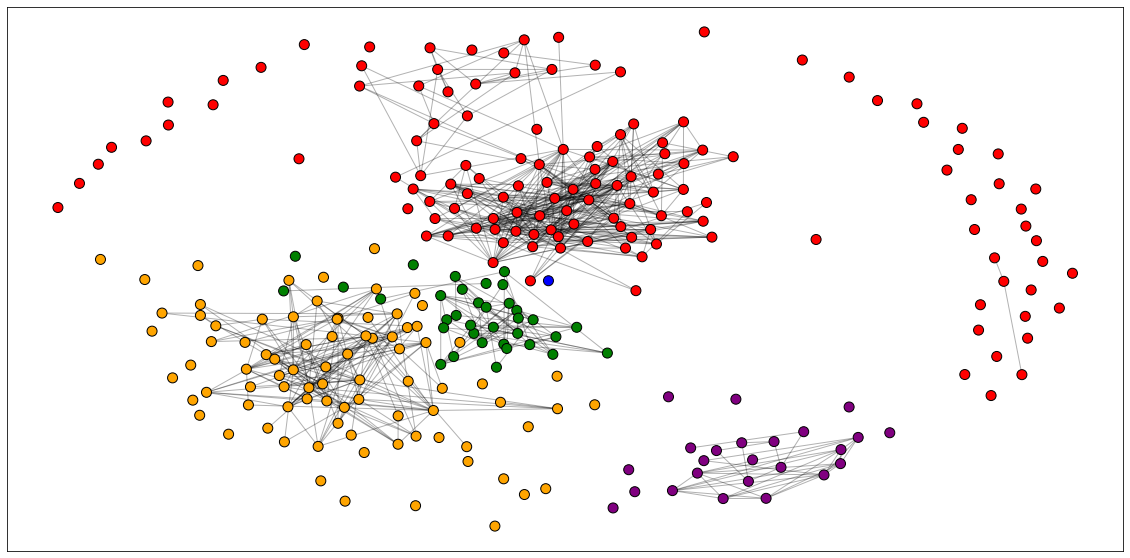

In [236]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G_copy, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G_copy, pos = pos, alpha = 0.3, edgelist = edges_to_add[:,:2])
plt.show()

### Final graph

The color black is for the original edges and the blue color for the new added edges

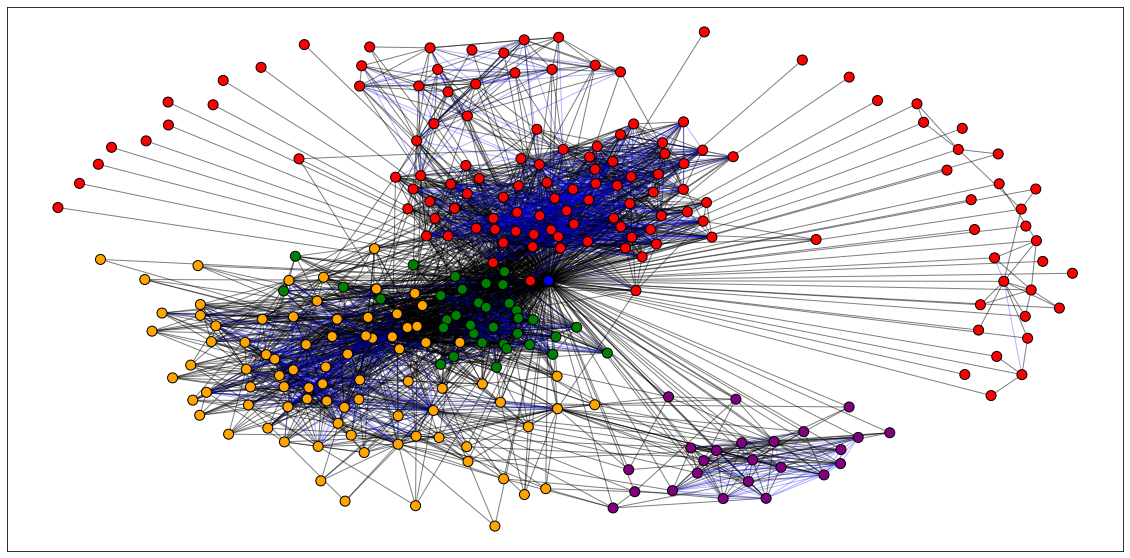

In [252]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G_copy, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G, pos = pos, alpha = .5, edge_color = 'black')
nx.draw_networkx_edges(G_copy, pos = pos, alpha = 0.3, edgelist = edges_to_add[:,:2], edge_color = 'blue')
plt.show()

## How this affected the original graph

In [254]:
print("Number of nodes: ", G_copy.number_of_nodes())
print("Number of edges: ", G_copy.number_of_edges())
avg = nx.algorithms.shortest_paths.generic.average_shortest_path_length(G_copy)
print("Average shortest path: ", avg)
d = nx.classes.function.density(G_copy)
print("Density: ", d)
cc = nx.algorithms.cluster.average_clustering(G_copy)
print("Cluster coefficient: ", cc)

Number of nodes:  280
Number of edges:  3608
Average shortest path:  1.9076292882744497
Density:  0.09237071172555043
Cluster coefficient:  0.6429229319849847


In [307]:
#getting the degrees of each node
values = [dgr[1] for dgr in G_copy.degree()]
#counting the degrees
count = Counter(values)

deg, cnt = zip(*count.items())

In [308]:
print("Average degree: ", np.mean(values))

Average degree:  25.771428571428572


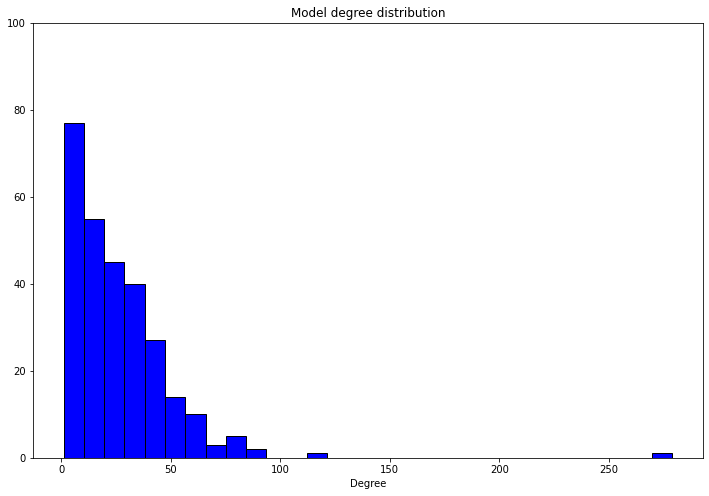

In [309]:
plt.figure(figsize=(12, 8))
plt.hist(values, bins = 30, color = 'blue', edgecolor = 'black')
plt.xlabel('Degree')
plt.title('Model degree distribution')
plt.ylim([0,100])
plt.show()

## Comparing to using the resource allocation index without using communities

In [265]:
list_ra = np.array(list(nx.algorithms.link_prediction.resource_allocation_index(G, not_connected_nodes)))

#### Min and Max

In [269]:
max(list_ra[:,2].astype(float))

1.2561269619340645

In [271]:
min(list_ra[:,2].astype(float))

0.0035842293906810036

In [275]:
edges_to_add_ra = list_ra[list_ra[:,2].astype(float) > .3]

In [280]:
print("new edges to add: ", len(edges_to_add_ra))

new edges to add:  994


In [277]:
G_copy2 = G.copy()

for nodeA, nodeB in edges_to_add_ra[:,:2]:
    
    G_copy2.add_edge(nodeA, nodeB)   

## Comparing network prior adding edges to after adding edges

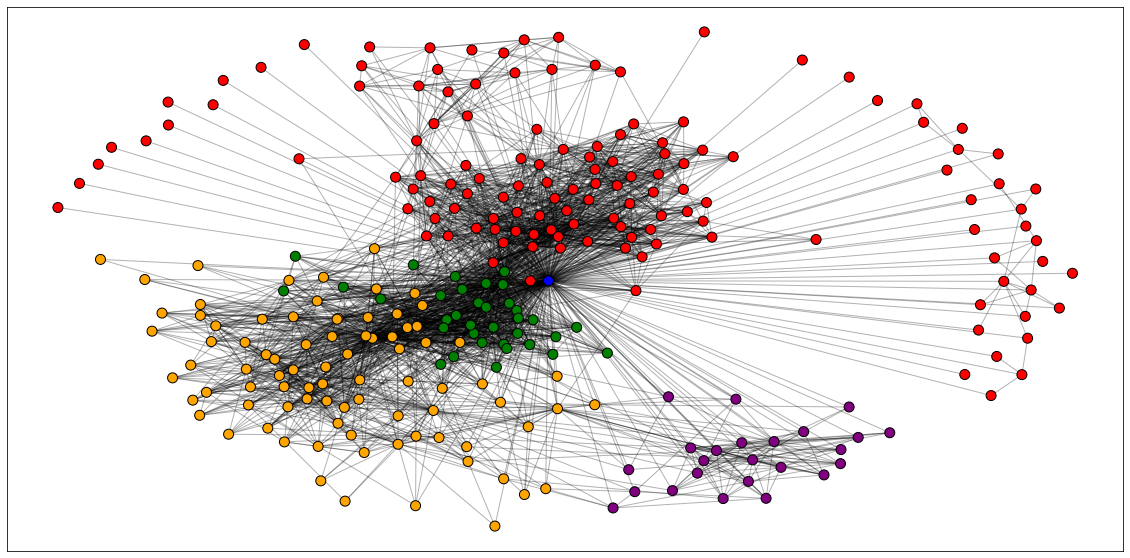

In [278]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G, pos = pos, alpha = 0.3)
plt.show()

### New edges

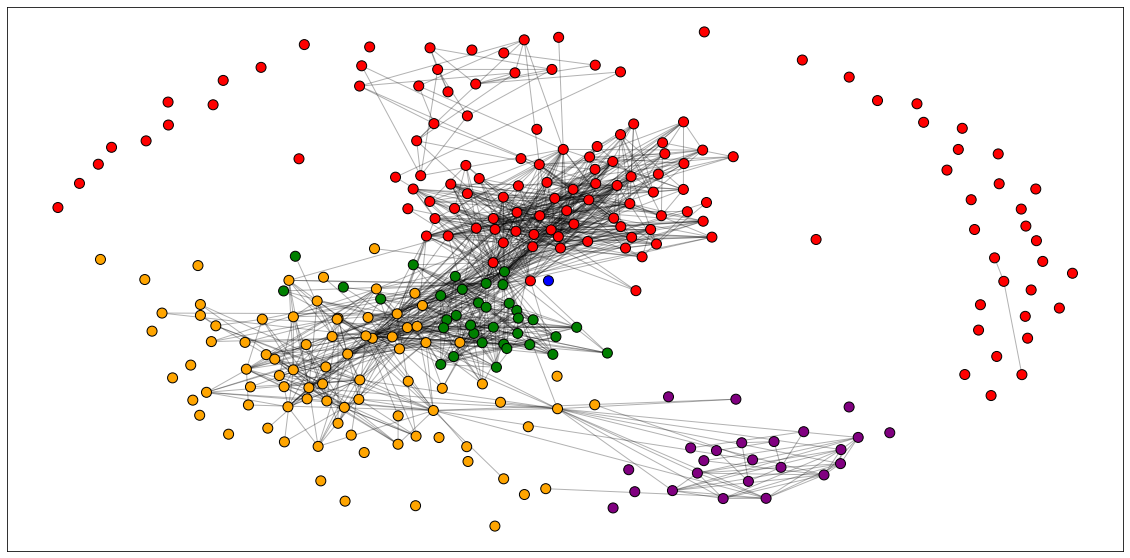

In [279]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G_copy2, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G_copy2, pos = pos, alpha = 0.3, edgelist = edges_to_add_ra[:,:2])
plt.show()

### Final graph

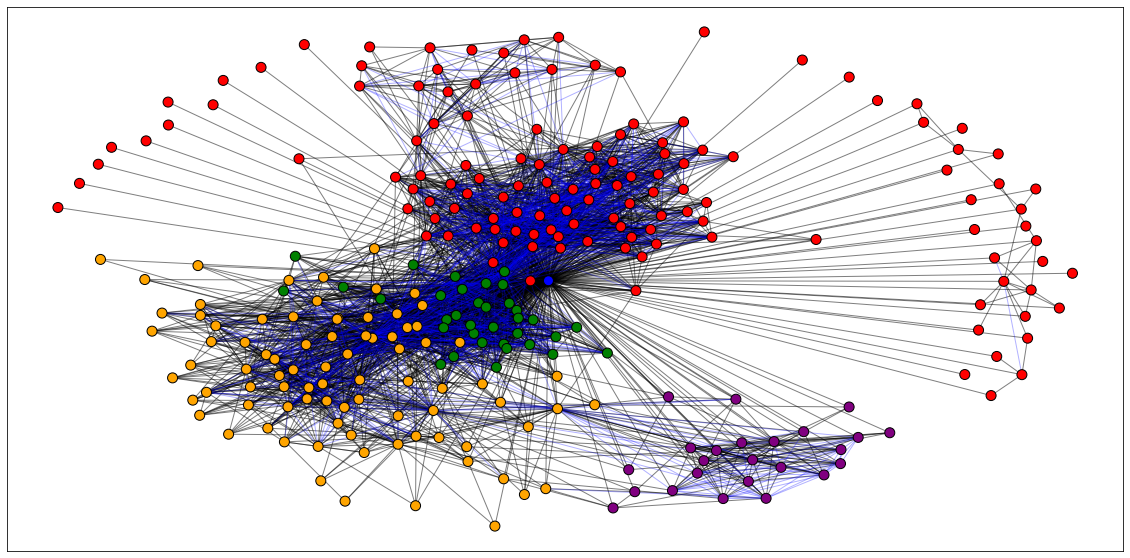

In [282]:
plt.figure(figsize = (20, 10))
nx.draw_networkx_nodes(G_copy2, pos = pos, node_size = 100, edgecolors = 'black', node_color = node_colors)
nx.draw_networkx_edges(G, pos = pos, alpha = .5, edge_color = 'black')
nx.draw_networkx_edges(G_copy2, pos = pos, alpha = 0.3, edgelist = edges_to_add_ra[:,:2], edge_color = 'blue')
plt.show()

## Affections

In [285]:
print("Number of nodes: ", G_copy2.number_of_nodes())
print("Number of edges: ", G_copy2.number_of_edges())
avg = nx.algorithms.shortest_paths.generic.average_shortest_path_length(G_copy2)
print("Average shortest path: ", avg)
d = nx.classes.function.density(G_copy2)
print("Density: ", d)
cc = nx.algorithms.cluster.average_clustering(G_copy2)
print("Cluster coefficient: ", cc)

Number of nodes:  280
Number of edges:  3975
Average shortest path:  1.8982334869431643
Density:  0.10176651305683564
Cluster coefficient:  0.6804790602439429


In [303]:
#getting the degrees of each node
values = [dgr[1] for dgr in G_copy2.degree()]
#counting the degrees
count = Counter(values)

deg, cnt = zip(*count.items())

In [304]:
print("average degree: ", np.mean(values))

average degree:  28.392857142857142


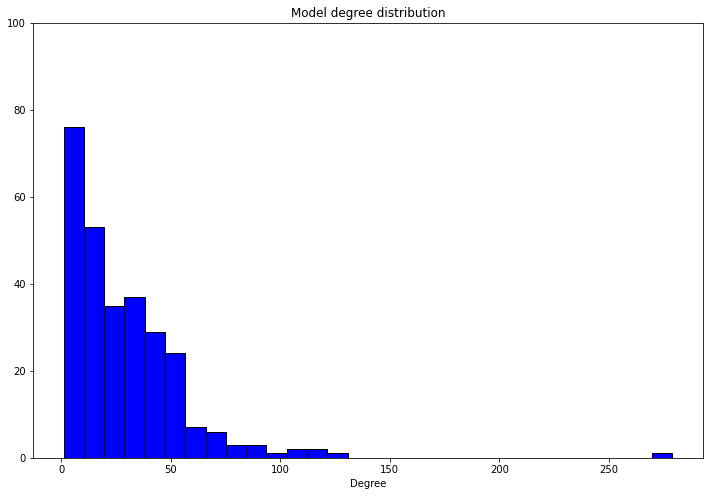

In [305]:
plt.figure(figsize=(12, 8))
plt.hist(values, bins = 30, color = 'blue', edgecolor = 'black')
plt.xlabel('Degree')
plt.title('Model degree distribution')
plt.ylim([0,100])
plt.show()